In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import random
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.model_selection import GridSearchCV
import requests
from io import BytesIO
from PIL import Image
from collections import Counter
from sklearn.decomposition import PCA
import joblib

In [3]:
path = '/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Train/crop_part1'
files = os.listdir(path)

In [4]:
image_files = random.sample(files, 9780)

In [5]:
input = []
target_age = []
for filename in image_files:
  if filename.endswith(".jpg"):
    actual_age = int(filename.split('_')[0])
    if actual_age >= 0 and actual_age <= 6:
      target_age.append(0)  # Trẻ em
    elif actual_age >= 7 and actual_age <= 19:
      target_age.append(1)  # Thiếu niên
    elif actual_age >= 20 and actual_age <=32 :
      target_age.append(2)  # Thanh niên
    elif actual_age >= 33 and actual_age <= 55:
      target_age.append(3)  # Trung niên
    else:  # actual_age >= 55
      target_age.append(4)  # Người cao tuổi
    input.append(path + '/' + filename)
  else:
    continue


In [6]:
print(len(target_age))

9780


In [7]:


age_counts = Counter(target_age)

print("Số lượng Trẻ em:", age_counts[0])
print("Số lượng Thiếu niên:", age_counts[1])
print("Số lượng Thanh niên:", age_counts[2])
print("Số lượng Trung niên:", age_counts[3])
print("Số lượng Người cao tuổi:", age_counts[4])


Số lượng Trẻ em: 2425
Số lượng Thiếu niên: 1739
Số lượng Thanh niên: 1864
Số lượng Trung niên: 1953
Số lượng Người cao tuổi: 1799


In [8]:
# Function to perform undersampling
def undersample(input_list, target_list, max_samples):
    indices = list(range(len(target_list)))
    random.shuffle(indices)
    sampled_indices = indices[:max_samples]
    return [input_list[i] for i in sampled_indices], [target_list[i] for i in sampled_indices]

In [9]:
# Determine the maximum number of samples per age group (e.g., 1000)
max_samples = 2000

# Create a balanced dataset
balanced_input = []
balanced_target_age = []
# Apply undersampling for each age group
for age_group in set(target_age):
    group_indices = [i for i, age in enumerate(target_age) if age == age_group]
    group_input = [input[i] for i in group_indices]
    group_target_age = [target_age[i] for i in group_indices]
    if len(group_target_age) > max_samples:
        group_input, group_target_age = undersample(group_input, group_target_age, max_samples)
    balanced_input.extend(group_input)
    balanced_target_age.extend(group_target_age)


In [10]:

age_counts = Counter(balanced_target_age)

print("Số lượng Trẻ em:", age_counts[0])
print("Số lượng Thiếu niên:", age_counts[1])
print("Số lượng Thanh niên:", age_counts[2])
print("Số lượng Trung niên:", age_counts[3])
print("Số lượng Người cao tuổi:", age_counts[4])


Số lượng Trẻ em: 2000
Số lượng Thiếu niên: 1739
Số lượng Thanh niên: 1864
Số lượng Trung niên: 1953
Số lượng Người cao tuổi: 1799


In [11]:
def canny_edge_detection(img, blur_ksize, threshold1, threshold2):
    """
    image_path: link to image
    blur_ksize: Gaussian kernel size
    threshold1: min threshold
    threshold2: max threshold
    """
    # Apply Gaussian blur
    blurred_img = cv2.GaussianBlur(img, (blur_ksize, blur_ksize), 0)

    # Perform Canny edge detection
    edges = cv2.Canny(blurred_img, threshold1, threshold2)

    return edges

In [12]:
def process_image(img_file):
    try:
        img = cv2.imread(img_file)
        img = cv2.resize(img, (128, 128))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_canny = canny_edge_detection(gray, 5, 50, 80)
        filename = os.path.basename(img_file)
        gender = int(filename.split('_')[1])
        return img_canny, gender
    except Exception as e:
        print(f"Error processing {img_file}: {e}")
        return None, None

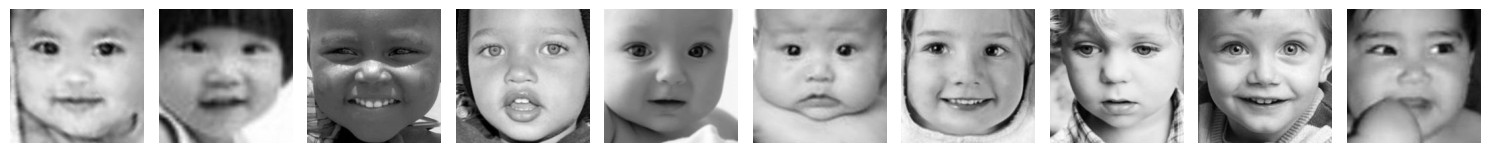

In [13]:
number_img = 10

fig, axes = plt.subplots(1, number_img, figsize=(15, 5))
for i, img_files in enumerate(balanced_input[0:number_img]):
  image_path = os.path.join(path, img_files)
  img = cv2.imread(image_path)

  # convert BGR to gray
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  axes[i].imshow(gray, cmap='gray')
  axes[i].axis('off')

plt.tight_layout()
plt.show()

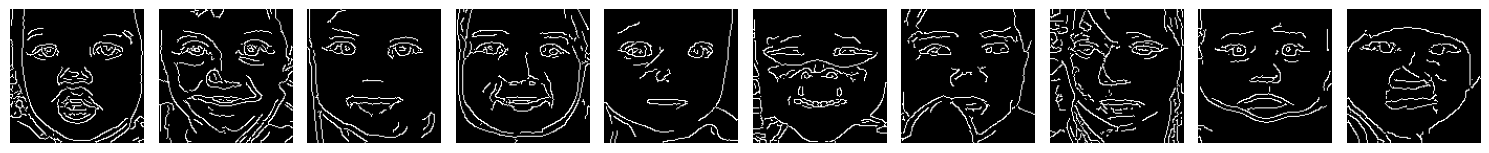

In [14]:
data = []
target_gender = []

# Number of images to visualize
number_img = 10
fig, axes = plt.subplots(1, number_img, figsize=(15, 5))

# Use ThreadPoolExecutor for parallel processing
with ThreadPoolExecutor(max_workers=8) as executor:
    future_to_img = {executor.submit(process_image, img_file): img_file for img_file in balanced_input}
    for i, future in enumerate(as_completed(future_to_img)):
        img_canny, gender = future.result()
        if img_canny is not None:
            data.append(img_canny)
            target_gender.append(gender)
            # Display the first number_img images
            if i < number_img:
                axes[i].imshow(img_canny, cmap='gray')
                axes[i].axis('off')

plt.tight_layout()
plt.show()

In [15]:
# Convert data and targets to numpy arrays
data = np.array(data)
target_gender = np.array(target_gender)
target_age = np.array(balanced_target_age)

In [16]:
  print(f"shape of data: {data.shape}")
  print(f"shape of target age: {target_age.shape}")
  print(f"shape of target gender: {target_gender.shape}")
  print(target_gender)

shape of data: (9355, 128, 128)
shape of target age: (9355,)
shape of target gender: (9355,)
[0 0 1 ... 1 1 1]


Visualizing Data

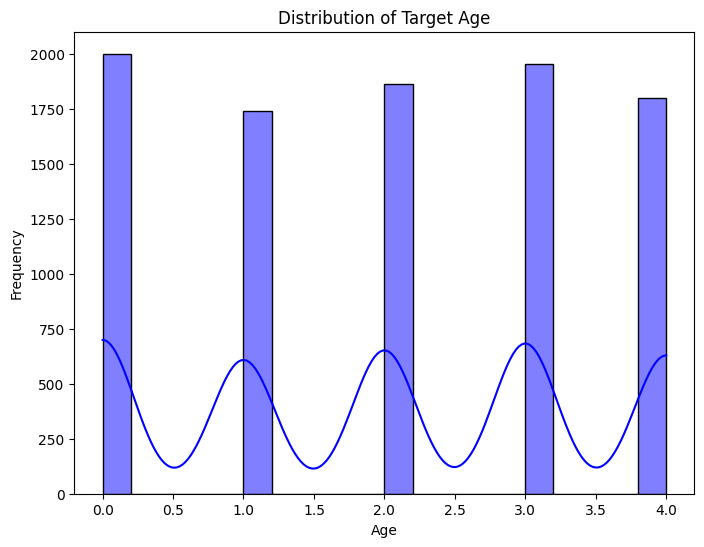

In [17]:
# Plotting target age
plt.figure(figsize=(8, 6))
sns.histplot(target_age, bins=20, kde=True, color='blue')
plt.title('Distribution of Target Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

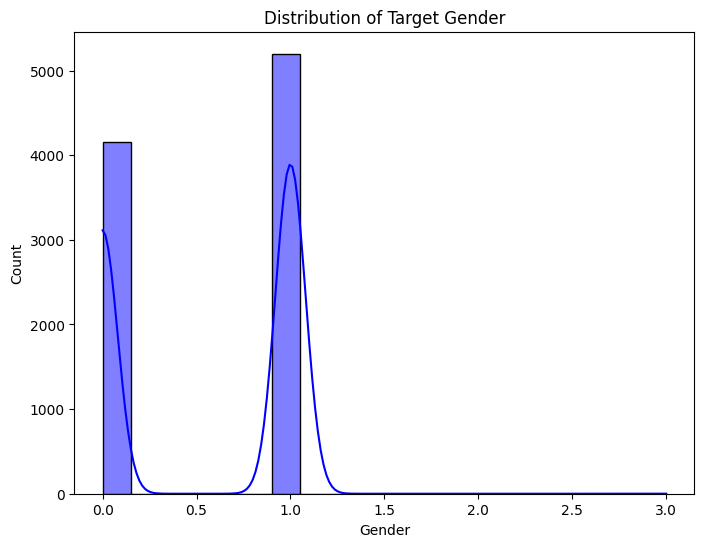

In [18]:
# Plotting target gender
plt.figure(figsize=(8, 6))
sns.histplot(target_gender, bins=20, kde=True, color='blue')
plt.title('Distribution of Target Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

Split data

In [19]:
  # Split the data into train and test sets
  X_train, X_test, y_train_gender, y_test_gender, y_train_age, y_test_age = train_test_split(data, target_gender, target_age, test_size=0.2, random_state=42)

  X_train = X_train.reshape(X_train.shape[0], -1)
  X_test = X_test.reshape(X_test.shape[0], -1)

In [20]:
  print(f"shape of X train: {X_train.shape}")
  print(f"shape of target age: {target_age.shape}")
  print(f"shape of target gender: {target_gender.shape}")

shape of X train: (7484, 16384)
shape of target age: (9355,)
shape of target gender: (9355,)


In [21]:

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [22]:

# Apply PCA for dimensionality reduction
pca = PCA(n_components=100)  # Adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [23]:
X_train_pca.shape

(7484, 100)

In [24]:
# Train the gender classifier
logistic_gender = LogisticRegression(solver='sag', max_iter = 300, random_state=42)
logistic_gender.fit(X_train_pca, y_train_gender)

# Train the age classifier
logistic_age = LogisticRegression(solver='sag', max_iter = 300, random_state=42)
logistic_age.fit(X_train_pca, y_train_age)

# Make predictions on the test set
y_pred_gender = logistic_gender.predict(X_test_pca)
y_pred_age = logistic_age.predict(X_test_pca)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [25]:
print(classification_report(y_test_gender, y_pred_gender))

              precision    recall  f1-score   support

           0       0.71      0.69      0.70       845
           1       0.75      0.77      0.76      1026

    accuracy                           0.73      1871
   macro avg       0.73      0.73      0.73      1871
weighted avg       0.73      0.73      0.73      1871



In [26]:
print(classification_report(y_test_age, y_pred_age))

              precision    recall  f1-score   support

           0       0.80      0.83      0.81       401
           1       0.49      0.50      0.50       332
           2       0.52      0.50      0.51       393
           3       0.48      0.46      0.47       392
           4       0.58      0.60      0.59       353

    accuracy                           0.58      1871
   macro avg       0.57      0.58      0.58      1871
weighted avg       0.58      0.58      0.58      1871



In [27]:

confusion_matrix(y_test_age, y_pred_age)

array([[332,  43,   9,   9,   8],
       [ 44, 167,  71,  29,  21],
       [ 13,  69, 197,  81,  33],
       [ 14,  36,  71, 179,  92],
       [ 14,  23,  32,  73, 211]])

In [28]:
# img_res = X_test_pca[10]
# res = logistic_age.predict(img_res.reshape(1, -1))  # Reshape to 2D (1 sample, -1 to infer the number of features)
# print(res)
# print(y_test_age[10])


In [29]:
def process_and_predict(file):
    img_origin = cv2.imread(file)
    if img_origin is None:
        raise ValueError(f"Image not found at path: {file}")

    img = cv2.resize(img_origin, (128, 128))

    # Convert BGR to gray
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_canny = canny_edge_detection(gray, 5, 50, 80)

    # Flatten and reshape for model input
    img_canny = img_canny.flatten().reshape(1, -1)

    # Scale the features (assuming scaler is already fitted on training data)
    img_canny = scaler.transform(img_canny)

    # Apply PCA for dimensionality reduction (assuming pca is already fitted on training data)
    img_canny = pca.transform(img_canny)

    # Predict age and gender
    age = logistic_age.predict(img_canny)
    gender = logistic_gender.predict(img_canny)

    # Interpret the results
    gender_label = 'male' if gender == 0 else 'female'
    age_labels = ['0-6', '7-19', '20-31', '32-55', '56+']
    age_label = age_labels[age[0]]

    # Display the original image with prediction results
    img_rgb = cv2.cvtColor(img_origin, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(f'Age: {age_label} \nGender: {gender_label}')
    plt.axis('off')
    plt.show()

In [30]:
def equalize_brightness(image):
    # Convert the image to YUV color space
    yuv_img = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    # Apply CLAHE to the Y channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    yuv_img[:, :, 0] = clahe.apply(yuv_img[:, :, 0])
    # Convert the YUV image back to BGR format
    equalized_img = cv2.cvtColor(yuv_img, cv2.COLOR_YUV2BGR)
    return equalized_img

In [31]:
def process_and_predict_url(url):
    # Download image from URL
    response = requests.get(url)
    img_origin = Image.open(BytesIO(response.content))
    img_origin = cv2.cvtColor(np.array(img_origin), cv2.COLOR_RGB2BGR)

    # Resize image
    img = cv2.resize(img_origin, (128, 128))

    # Equalize brightness
    img_equalized = equalize_brightness(img)

    # Convert BGR to gray
    gray = cv2.cvtColor(img_equalized, cv2.COLOR_BGR2GRAY)
    img_canny = canny_edge_detection(gray, 5, 100, 200)

    # Flatten and reshape for model input
    img_canny = img_canny.flatten().reshape(1, -1)

    # Scale the features (assumes scaler is already fitted on training data)
    img_canny = scaler.transform(img_canny)

    # Apply PCA for dimensionality reduction (assuming pca is already fitted on training data)
    img_canny = pca.transform(img_canny)

    # Predict age and gender
    age = logistic_age.predict(img_canny)
    gender = logistic_gender.predict(img_canny)

    # Interpret the results
    gender_label = 'male' if gender == 0 else 'female'
    age_labels = ['0-6', '7-19', '20-31', '32-55', '56+']
    age_label = age_labels[age[0]]

    # Display the original image with prediction results
    img_rgb = cv2.cvtColor(img_origin, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(f'Age: {age_label} \nGender: {gender_label}')
    plt.axis('off')
    plt.show()


In [32]:

def process_and_show_canny(url):
    # Download image from URL
    response = requests.get(url)
    img_origin = Image.open(BytesIO(response.content))
    img_origin = cv2.cvtColor(np.array(img_origin), cv2.COLOR_RGB2BGR)

    # Resize image
    img = cv2.resize(img_origin, (128, 128))
    img_equalized = equalize_brightness(img)

    # Convert BGR to gray
    gray = cv2.cvtColor(img_equalized, cv2.COLOR_BGR2GRAY)
    img_canny = canny_edge_detection(gray, 5, 150, 200)

    # Display the original image and the edge-detected image
    img_rgb = cv2.cvtColor(img_origin, cv2.COLOR_BGR2RGB)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(img_rgb)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(img_canny, cmap='gray')
    axs[1].set_title('Canny Edge Detection')
    axs[1].axis('off')

    plt.show()

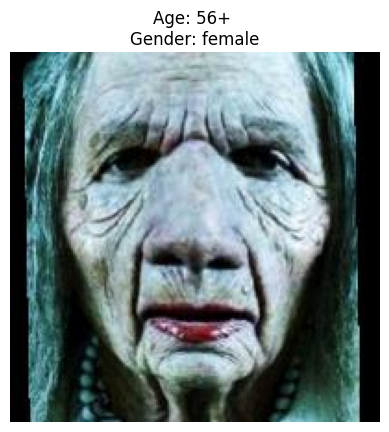

In [33]:
process_and_predict('/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Train/crop_part1/110_1_3_20170110155139762.jpg.chip.jpg')

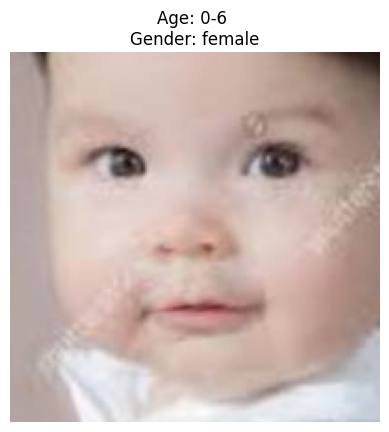

In [34]:
process_and_predict('/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Train/crop_part1/1_0_0_20161219140627985.jpg.chip.jpg')

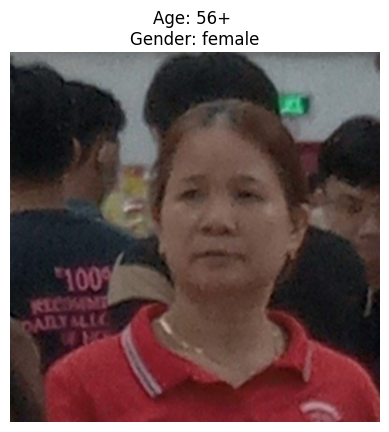

In [35]:
process_and_predict('/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Test/img11.jpg')


In [36]:
# process_and_predict_url('https://scontent.fsgn16-1.fna.fbcdn.net/v/t39.30808-6/377428571_1340925369838047_5374658122085579002_n.jpg?_nc_cat=105&ccb=1-7&_nc_sid=5f2048&_nc_eui2=AeFOQZMw4BC8v7z5qtAWjYuxoGAMlp41i8ugYAyWnjWLy049IFz3d-JZq280HNo-G8oVRXfA610JOOo0xeEObFxJ&_nc_ohc=j8P9mnwWfOIQ7kNvgGhUN_i&_nc_ht=scontent.fsgn16-1.fna&oh=00_AYDVebCN0_o1cFfD_ypgdXYOMoiMNv7eXz4dKXz4KfAfkA&oe=664F752C')

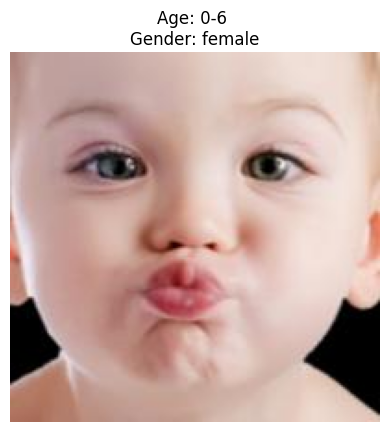

In [37]:
process_and_predict('/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Train/crop_part1/1_0_0_20170110212658392.jpg.chip.jpg')

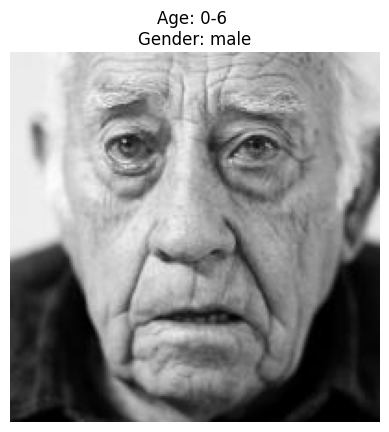

In [38]:
process_and_predict('/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Train/crop_part1/90_0_0_20170111205428761.jpg.chip.jpg')

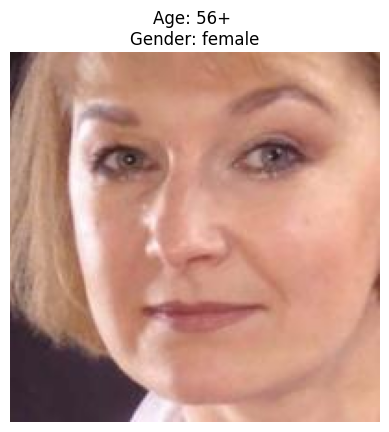

In [39]:
process_and_predict('/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Train/crop_part1/60_1_0_20170110124140071.jpg.chip.jpg')

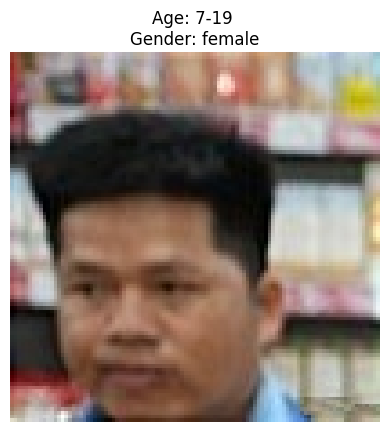

In [40]:
process_and_predict('/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Test/img24.jpg')

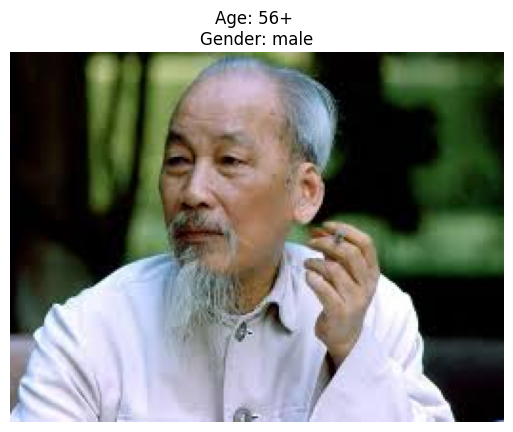

In [41]:
process_and_predict_url('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSOjp_5WCodyvvr_-3az-bXcnjwfu8yGGSHLW33CgXnUQ&s')

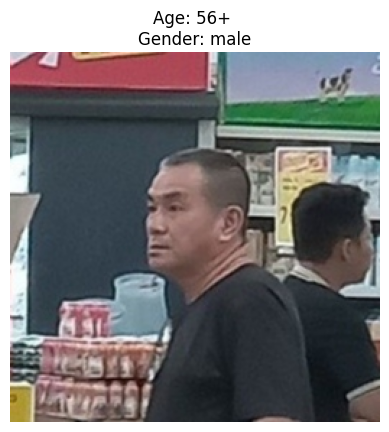

In [42]:
process_and_predict('/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Test/img2.jpg')

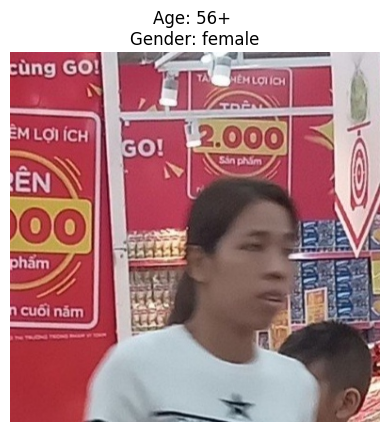

In [43]:
process_and_predict('/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Test/img15.jpg')

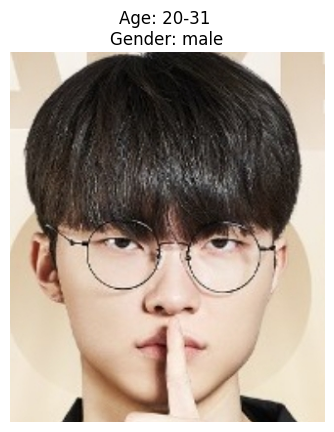

In [44]:
process_and_predict('/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Test/img26.jpg')

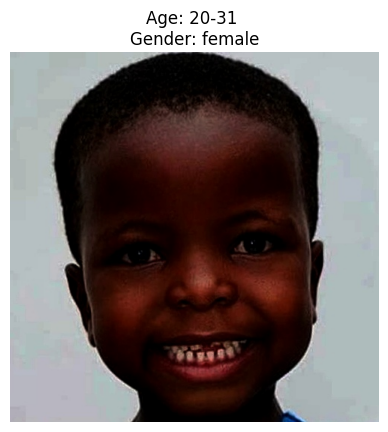

In [45]:
process_and_predict('/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Test/img30.jpg')

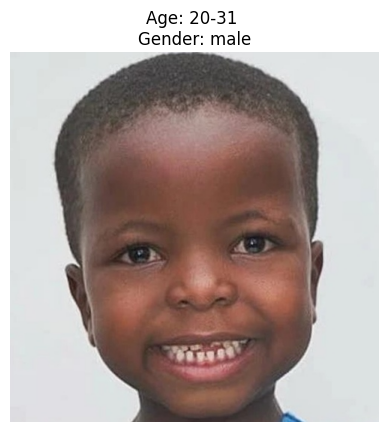

In [46]:
process_and_predict('/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Test/img31.jpg')

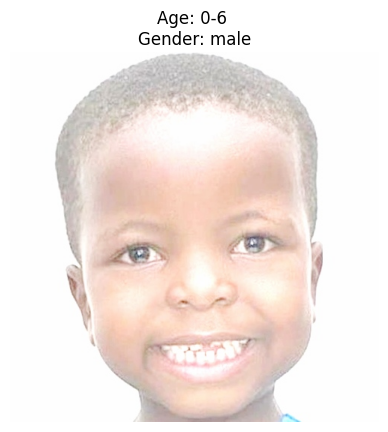

In [47]:
process_and_predict('/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Test/img32.jpg')

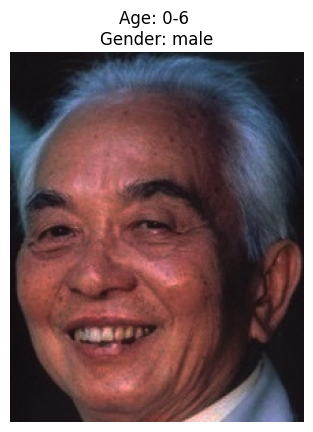

In [48]:
process_and_predict('/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Test/img33.jpg')

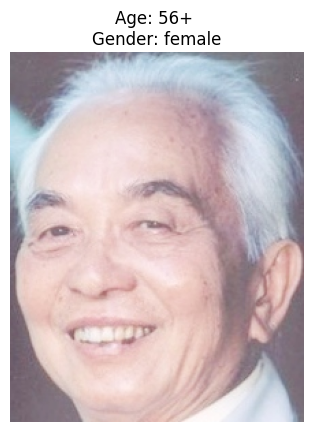

In [49]:
process_and_predict('/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Test/img34.jpg')

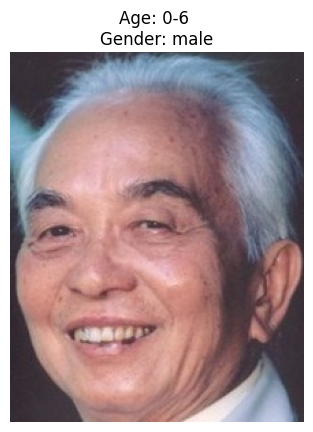

In [50]:
process_and_predict('/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Test/img35.jpg')

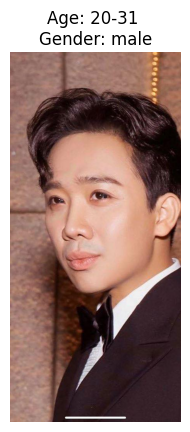

In [51]:
process_and_predict_url('https://s1.media.ngoisao.vn/resize_580/news/2020/01/16/8214411922582978277965377657657441563181056n-ngoisao.vn-w443-h960.jpg')

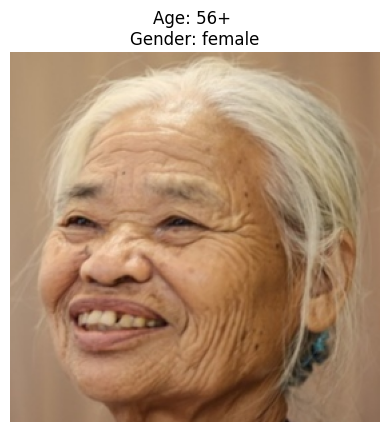

In [52]:
process_and_predict('/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Test/img36.jpg')

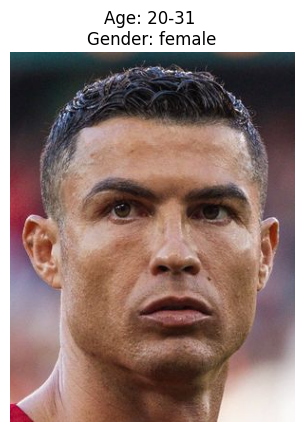

In [53]:
process_and_predict_url('https://img.a.transfermarkt.technology/portrait/big/8198-1694609670.jpg?lm=1')

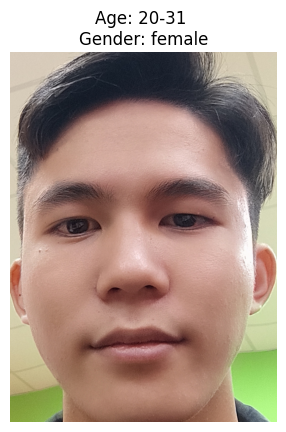

In [54]:
process_and_predict('/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Test/vinh.jpg')


In [55]:
joblib_file = "/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Pre-trained/Gender_Logistic_Model.pkl"
joblib.dump(logistic_gender, joblib_file)

['/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Pre-trained/Gender_Logistic_Model.pkl']

In [56]:
joblib_file = "/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Pre-trained/Age_Logistic_Model.pkl"
joblib.dump(logistic_age, joblib_file)

['/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Pre-trained/Age_Logistic_Model.pkl']